In [1]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os

# load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np.squeeze(y_train)
print('data loaded')

Using TensorFlow backend.


data loaded


In [2]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')

model loaded


In [3]:
# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                            for i in range(0, len(x_train))]).astype('float32')
    inception_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
print('bottleneck features saved (train)')

bottleneck features detected (train)
bottleneck features saved (train)


In [4]:
# obtain bottleneck features (test)
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                       for i in range(0, len(x_test))]).astype('float32')
    inception_input_test = preprocess_input(big_x_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features detected (test)
bottleneck features saved (test)


In [5]:
from keras.utils import np_utils

# one-hot encode the labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [8]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization

model = Sequential()
# model.add(Conv2D(filters=100, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dense(256, activation='relu', input_shape=features.shape[1:]))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3, 3, 256)         524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 3, 3, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                23050     
Total params: 548,618
Trainable params: 548,106
Non-trainable params: 512
_________________________________________________________________


In [9]:
# from keras import regularizers, optimizers

# optimizer = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', verbose=2, save_best_only=True)

history = model.fit(features, y_train, batch_size=64, epochs=20,
          validation_split=0.1, callbacks=[checkpointer],
          verbose=2, shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
 - 27s - loss: 0.6645 - acc: 0.7829 - val_loss: 0.5462 - val_acc: 0.8142

Epoch 00001: val_loss improved from inf to 0.54619, saving model to model.best.hdf5
Epoch 2/20
 - 15s - loss: 0.4930 - acc: 0.8347 - val_loss: 0.5294 - val_acc: 0.8266

Epoch 00002: val_loss improved from 0.54619 to 0.52935, saving model to model.best.hdf5
Epoch 3/20
 - 15s - loss: 0.4151 - acc: 0.8586 - val_loss: 0.5157 - val_acc: 0.8356

Epoch 00003: val_loss improved from 0.52935 to 0.51570, saving model to model.best.hdf5
Epoch 4/20
 - 15s - loss: 0.3616 - acc: 0.8754 - val_loss: 0.5622 - val_acc: 0.8310

Epoch 00004: val_loss did not improve from 0.51570
Epoch 5/20
 - 15s - loss: 0.3215 - acc: 0.8896 - val_loss: 0.5420 - val_acc: 0.8404

Epoch 00005: val_loss did not improve from 0.51570
Epoch 6/20
 - 15s - loss: 0.2791 - acc: 0.9030 - val_loss: 0.5562 - val_acc: 0.8332

Epoch 00006: val_loss did not improve from 0.51570
Epoch 7/20
 - 15s - loss: 0.

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(features_test, y_test, verbose=1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

10000/10000 [==============================] - 2s 173us/step
Test accuracy: 83.3400%


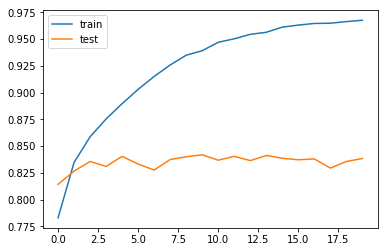

In [11]:
from matplotlib import pyplot
%matplotlib inline

# plot learning curves of model accuracy
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
# evaluate test accuracy
score = model.evaluate(features, y_train, verbose=1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

50000/50000 [==============================] - 8s 163us/step
Test accuracy: 88.5780%
